In [42]:
# Run in terminal or command prompt
import numpy as np
import pandas as pd
import re, nltk

%matplotlib inline

import warnings
#from text_unidecode import unidecode
from collections import deque
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from node2vec import Node2Vec

sns.set_style('whitegrid')

In [129]:
import types
import pandas as pd
from ibm_botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_d812e9ff73554acb99ec832832ddfe49 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='-rPWCJ6tlad28m4TQMS_rhBCiHbQ4d2agItYcfqgqzen',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_d812e9ff73554acb99ec832832ddfe49.get_object(Bucket='progpy19cabd749c62e43b992119d84b67f744f', Key='AllRecipesInitial.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 )
    

    

In [130]:
dataset = pd.read_excel(streaming_body_1)

In [131]:
dataset['ingredient'] = dataset['ingredient'].apply(lambda x: x.replace(" ","_"))  #apply(lambda x: "%s" % '_'.join(x))
dataset['ingredient'] = dataset['ingredient'].apply(lambda x: x.replace("agar_agaragar_agar", "agar_agar"))
len(dataset)
#print("The length of the Dataset with all URL is : " len(dataset))

198090

In [132]:
#dataset['url'].replace('', np.nan, inplace=True)

#dataset['url'] = dataset.dropna(subset=['url'], inplace = True)
#len(dataset)

In [133]:
data = dataset.drop(['recipe_title','amount','unit_of_measurement', 'instructions', 'url'], axis = 1)
#data.head()
len(set(data['ID']))

22323

In [134]:
data_id = set(data['ID'])
List_graph = []
for i in range (len(data)):
    List_graph.append((data['ID'][i],data['ingredient'][i]))
len(List_graph)

198090

In [51]:
#Save the Graph ready data as CSV file for spark session. .....removing it though
#Recipe_GraphReady = pd.DataFrame(List_graph)

In [52]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
'''from project_lib import Project
project = Project(sc, '41799493-7493-4323-a0c8-18d6a9437a1e', 'p-0e16a4f68d1452f5db09295ab29ff95c32ed4397')
pc = project.project_context


# let's assume you have the pandas DataFrame  pandas_df which contains the data
# you want to save in your object storage as a csv file

project.save_data("Recipe_GraphReady.csv", (pd.DataFrame(Recipe_GraphReady)).to_csv(), overwrite = True)'''


'from project_lib import Project\nproject = Project(sc, \'41799493-7493-4323-a0c8-18d6a9437a1e\', \'p-0e16a4f68d1452f5db09295ab29ff95c32ed4397\')\npc = project.project_context\n\n\n# let\'s assume you have the pandas DataFrame  pandas_df which contains the data\n# you want to save in your object storage as a csv file\n\nproject.save_data("Recipe_GraphReady.csv", (pd.DataFrame(Recipe_GraphReady)).to_csv(), overwrite = True)'

Name: 
Type: Graph
Number of nodes: 62
Number of edges: 96
Average degree:   3.0968


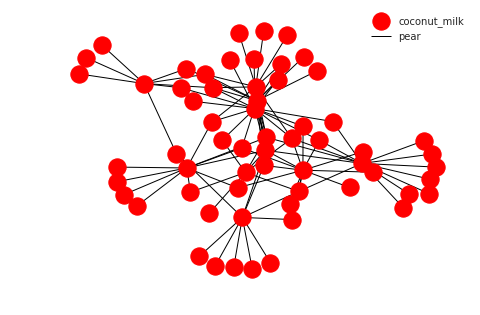

In [183]:
g = nx.Graph()
g.add_edges_from(List_graph[0:900])
#g.add_edges_from(List_graph[0:100])
print(nx.info(g))
nx.draw(g)
plt.legend(g)
plt.show(g)

# Node2Vec Algorithm

In [137]:
node2vec = Node2Vec(g, dimensions=500, walk_length=300, num_walks=20, workers=10)

Computing transition probabilities: 100%|██████████| 14116/14116 [13:30<00:00, 17.42it/s]


In [111]:
model = node2vec.fit(window=10, min_count=10)

In [191]:
#Find reccomendationed nodes
for node, _ in model.most_similar('strawberry'):
    # Show only players
    #if len(node) > 3:
    print(node)
    print(_)

preserving_sugar
0.4687490165233612
whipped_cream
0.4476786255836487
crisp_biscuit
0.418484091758728
low_fat_biscuit
0.3603917062282562
rose_wine
0.3512873351573944
balsamic_vinegar
0.3512839376926422
bread_gluten_free_loaf
0.3509503901004791
raspberry_strawberry
0.34834253787994385
champagne
0.3465920388698578
wild_strawberry
0.3460548520088196


# Visualization

In [153]:
similar_nodes = [x for x in model.wv.vocab if x not in set(data['ID'])]
embeddings = np.array([model.wv[x] for x in similar_nodes])

In [154]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

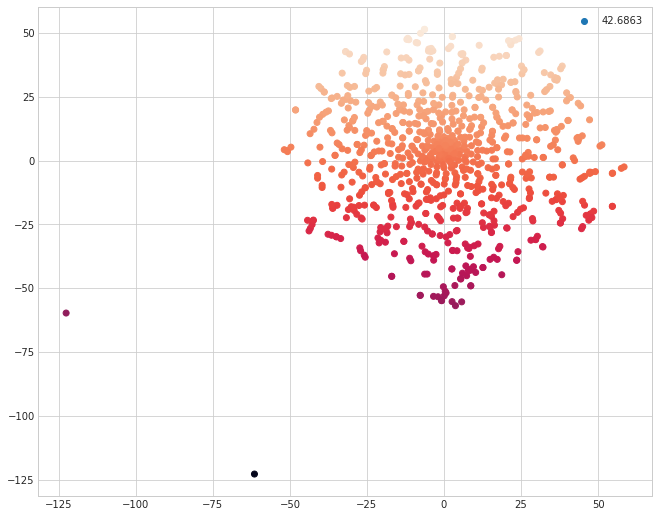

In [175]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c= embeddings_2d[:,1])
ax.legend(embeddings_2d[:, 0])
ax.legend(embeddings_2d[:, 1])

In [223]:
List_test = []

for i in range(5,50,5):
    List_test.append(List_graph[:98000][i][1])
List_test

['salt',
 'full_cream',
 'sugar',
 'butter',
 'butter',
 'water',
 'coconut_milk',
 'quark',
 'full_cream']

In [224]:
#Find reccomendationed nodes
Test_output = []
for i in range(len(List_test)):
    Test_output.append(List_test[i])
    Test_output.append("++++++++++++++++++++++++++++++++++++++++test")
    for node, _ in model.most_similar(List_test[i], topn = 3):
        Test_output.append(node)
    Test_output.append("--------------------------------------------")
    Test_output.append("----------------------------------------Next")
Test_output    

['salt',
 '++++++++++++++++++++++++++++++++++++++++test',
 'gingerbread_spice',
 'pear_concentrate',
 'white_flour',
 '--------------------------------------------',
 '----------------------------------------Next',
 'full_cream',
 '++++++++++++++++++++++++++++++++++++++++test',
 'williams_pear_schnapps',
 'fleur_de_sel',
 'pear_concentrate',
 '--------------------------------------------',
 '----------------------------------------Next',
 'sugar',
 '++++++++++++++++++++++++++++++++++++++++test',
 'white_flour',
 'yoghurt',
 'gingerbread_spice',
 '--------------------------------------------',
 '----------------------------------------Next',
 'butter',
 '++++++++++++++++++++++++++++++++++++++++test',
 'egg',
 'plain_flour',
 'caster_sugar',
 '--------------------------------------------',
 '----------------------------------------Next',
 'butter',
 '++++++++++++++++++++++++++++++++++++++++test',
 'egg',
 'plain_flour',
 'caster_sugar',
 '--------------------------------------------',
 '